<a href="https://colab.research.google.com/github/smatsuda6/mlprojects/blob/main/Codeathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CODEATHON 3: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](http://faculty.virginia.edu/lazzara/images/UVAgrounds.jpg) 

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture. 

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 50 points for this codeathon plus 10 bonus points if (1) your classifier performs exceed 95% accuracy OR you try at least 3 different architectures and able to analyze their performance.

To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Collab with the following format: yourcomputingID_codeathon_3.ipynb

Best of luck, and have fun! 

# Load Packages

In [ ]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(49)
tf.random.set_seed(49)

# Import Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my AWS server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [ ]:
# Download dataset from AWS
!wget https://uvalandmark20.s3.amazonaws.com/dataset_split.zip

--2020-04-21 02:29:46--  https://uvalandmark20.s3.amazonaws.com/dataset_split.zip
Resolving uvalandmark20.s3.amazonaws.com (uvalandmark20.s3.amazonaws.com)... 52.216.236.75
Connecting to uvalandmark20.s3.amazonaws.com (uvalandmark20.s3.amazonaws.com)|52.216.236.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397586818 (379M) [application/zip]
Saving to: ‘dataset_split.zip’

dataset_split.zip   100%[===================>] 379.17M  88.3MB/s    in 4.4s    

2020-04-21 02:29:50 (86.4 MB/s) - ‘dataset_split.zip’ saved [397586818/397586818]



In [ ]:
# Extract content
!unzip "/content/dataset_split.zip"

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/train/Rotunda/._0000010368.jpg  
  inflating: train/Rotunda/0000009639.jpg  
  inflating: __MACOSX/train/Rotunda/._0000009639.jpg  
  inflating: train/Rotunda/0000010591.jpg  
  inflating: __MACOSX/train/Rotunda/._0000010591.jpg  
  inflating: train/Rotunda/0000010585.jpg  
  inflating: __MACOSX/train/Rotunda/._0000010585.jpg  
  inflating: train/Rotunda/0000009942.jpg  
  inflating: __MACOSX/train/Rotunda/._0000009942.jpg  
  inflating: train/Rotunda/0000009956.jpg  
  inflating: __MACOSX/train/Rotunda/._0000009956.jpg  
  inflating: train/Rotunda/0000009765.jpg  
  inflating: __MACOSX/train/Rotunda/._0000009765.jpg  
  inflating: train/Rotunda/0000010234.jpg  
  inflating: __MACOSX/train/Rotunda/._0000010234.jpg  
  inflating: train/Rotunda/0000010552.jpg  
  inflating: __MACOSX/train/Rotunda/._0000010552.jpg  
  inflating: train/Rotunda/0000010546.jpg  
  inflating: __MACOSX/train/Rotunda/._0000010546.jpg  
  i

In [ ]:
from sklearn.datasets import load_files 
from keras.utils import np_utils
from sklearn.model_selection import train_test_split


# define function to load train, test, and validation datasets
def load_dataset(path, num_classes):
    #Load text files with categories as subfolder names.
    data = load_files(path)
    filenames = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), num_classes)
    return filenames, targets

n_classes = 18;
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 
  'BravoHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 
  'ThorntonHall', 'UniversityChapel']

files, targets = load_dataset('/content/train/',n_classes)
# Split to train-validate-test sets. DO NOT CHANGE THE TEST RATIO OR RANDOM STATE
train_files, val_files, train_targets, val_targets = train_test_split(files, targets, test_size=0.2, random_state=49)

# IMPORTANCE: You must evaluate your performance based on this test set.
test_files, test_targets = load_dataset('/content/test/',n_classes)

Using TensorFlow backend.


In [ ]:
from keras.preprocessing import image
from tqdm import tqdm # progress bar

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)           

# pre-process the data for Keras - Converts to (224, 224) and converts into a numpy array using PIL.
# NOTE: This code does not include any data augmentation, but you can modify it to include the augmentation operation.


#Data augmentation

# from keras.preprocessing.image import ImageDataGenerator
# samples = expand_dims(data, 0)

# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)
# train_generator = train_datagen.flow_from_directory(
#         train_files,
#         target_size=(224, 224),
#         batch_size=32,
#         color_mode="rgb",
#         class_mode='categorical')


X_train = paths_to_tensor(train_files).astype('float32')/255
X_val = paths_to_tensor(val_files).astype('float32')/255
X_test = paths_to_tensor(test_files).astype('float32')/255
# Convert y_targets into labels
y_train = np.asarray([np.where(r==1)[0][0] for r in train_targets], dtype=np.uint8)
y_test = np.asarray([np.where(r==1)[0][0] for r in test_targets], dtype=np.uint8)
y_val = np.asarray([np.where(r==1)[0][0] for r in val_targets], dtype=np.uint8)

100%|██████████| 1800/1800 [00:03<00:00, 490.96it/s]


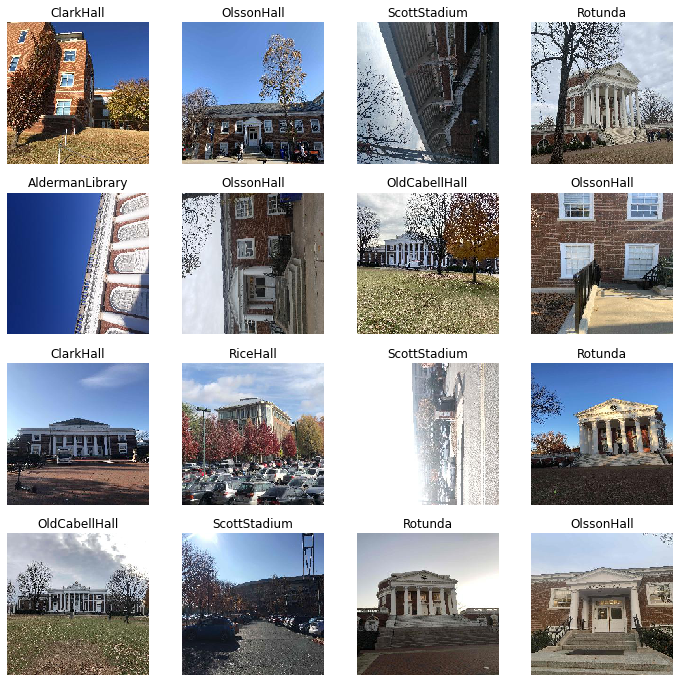

In [ ]:
# Visualize some of the train samples
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


# It's your turn: Building a classifier for UVA Landmark Dataset
You may design your own architecture OR re-use any of the exising frameworks. 

Best of luck!

In [ ]:
# YOUR CODE STARTS HERE

base_model = keras.applications.xception.Xception(weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)


batch_size = 64
dataset_size = y_train.size
print(y_train.size)
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
model.summary()



10003
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
________________________________________________________________________________________

In [ ]:
history = model.fit(x=X_train,y=y_train,
                    steps_per_epoch=int(.75*dataset_size / batch_size),
                    validation_data=(X_val,y_val),
                    validation_steps=int(.15 * dataset_size / batch_size),
                    epochs=3)

Epoch 1/3
156/156 [==============================] - 1016s 7s/step - loss: 0.5491 - accuracy: 0.8558 - val_loss: 1.0033 - val_accuracy: 0.7293
Epoch 2/3
156/156 [==============================] - 1026s 7s/step - loss: 0.1248 - accuracy: 0.9692 - val_loss: 0.2364 - val_accuracy: 0.9388
Epoch 3/3
150/156 [===========================>..] - 992s 7s/step - loss: 0.0305 - accuracy: 0.9913 - val_loss: 0.1664 - val_accuracy: 0.9676


# Accuracy score is .84 for the test set and .96 on the validation set.

In [ ]:
model.evaluate(X_test, y_test)

57/57 [==============================] - 33s 577ms/step - loss: 0.7768 - accuracy: 0.8439


[0.7768489122390747, 0.8438888788223267]

In [ ]:


base_model2 = keras.applications.resnet50.ResNet50(weights="imagenet",include_top=False)
avg2 = keras.layers.GlobalAveragePooling2D()(base_model2.output)
output2 = keras.layers.Dense(n_classes, activation="softmax")(avg2)
model2 = keras.models.Model(inputs=base_model2.input, outputs=output2)


batch_size = 64
dataset_size = y_train.size
print(y_train.size)
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model2.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
model2.summary()



10003
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [ ]:
history2 = model2.fit(x=X_train,y=y_train,
                    steps_per_epoch=int(.75*dataset_size / batch_size),
                    validation_data=(X_val,y_val),
                    validation_steps=int(.15 * dataset_size / batch_size),
                    epochs=3)

Epoch 1/3
117/117 [==============================] - 802s 7s/step - loss: 4.1063 - accuracy: 0.1187 - val_loss: 4.8981 - val_accuracy: 0.1168
Epoch 2/3
117/117 [==============================] - 793s 7s/step - loss: 2.8065 - accuracy: 0.1364 - val_loss: 2.7686 - val_accuracy: 0.1132
Epoch 3/3
117/117 [==============================] - 786s 7s/step - loss: 2.7283 - accuracy: 0.1497 - val_loss: 2.7753 - val_accuracy: 0.1132


In [ ]:
model2.evaluate(X_test, y_test)

57/57 [==============================] - 25s 441ms/step - loss: 3.0652 - accuracy: 0.0556


[3.0651566982269287, 0.0555555559694767]

In [ ]:
base_model3 = keras.applications.inception_v3.InceptionV3(weights="imagenet",include_top=False)
avg3 = keras.layers.GlobalAveragePooling2D()(base_model3.output)
output3 = keras.layers.Dense(n_classes, activation="softmax")(avg3)
model3 = keras.models.Model(inputs=base_model3.input, outputs=output3)


batch_size = 64
dataset_size = y_train.size
print(y_train.size)
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model3.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
model3.summary()

10003
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_122 (BatchN (None, None, None, 3 96          conv2d_122[0][0]                 
__________________________________________________________________________________________________
activation_121 (Activation)     (None, None, None, 3 0           batch_normalization_122[0][0]    
______________________________________________________________________________________

In [ ]:
history3 = model3.fit(x=X_train,y=y_train,
                    steps_per_epoch=int(.5*dataset_size / batch_size),
                    validation_data=(X_val,y_val),
                    validation_steps=int(.15 * dataset_size / batch_size),
                    epochs=3)

Epoch 1/3
78/78 [==============================] - 525s 7s/step - loss: 2.9539 - accuracy: 0.1222 - val_loss: 1590253312.0000 - val_accuracy: 0.0584
Epoch 2/3
78/78 [==============================] - 515s 7s/step - loss: 2.7872 - accuracy: 0.1098 - val_loss: 394.2625 - val_accuracy: 0.1132
Epoch 3/3
78/78 [==============================] - 509s 7s/step - loss: 2.7543 - accuracy: 0.1186 - val_loss: 34.6629 - val_accuracy: 0.1132


In [ ]:
model3.evaluate(X_test, y_test)

57/57 [==============================] - 13s 229ms/step - loss: 81.5016 - accuracy: 0.0633


[81.50159454345703, 0.06333333253860474]